# **Setup and Package Installation**



In [176]:
# Downloading yfinance for stock prices data
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [177]:
#importing necessary libraries
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt

#prevent SettingWithCopyWarning message from appearing
pd.options.mode.chained_assignment = None

# **Downloading the Market Index Data**
As a sample, we have selected the Nifty 50 Index over a 2 year trading period.

In [178]:
# on average there are 252 trading days in a year
NUM_TRADING_DAYS = 252

# historical data - define START and END dates
start_date = '2020-01-01'
end_date = '2022-11-30'

# stocks we are going to handle
stocks = ['^NSEI']

# Creating dataframe for the stock prices
def download_data():
    # name of the stock (key) - stock values (2010-1017) as the values
    stock_data = {}

    for stock in stocks:
        # closing prices
        ticker = yf.Ticker(stock)
        stock_data['Close'] = ticker.history(start=start_date, end=end_date)['Close']
        stock_data['Open'] = ticker.history(start=start_date, end=end_date)['Open']
        stock_data['High'] = ticker.history(start=start_date, end=end_date)['High']
        stock_data['Low'] = ticker.history(start=start_date, end=end_date)['Low']
        stock_data['Volume'] = ticker.history(start=start_date, end=end_date)['Volume']

    return pd.DataFrame(stock_data)

# Returns Function
Creating a Function to calculate returns by simulating trades based on signal

In [179]:
#Calculating Returns
def returns(ds):
    losstrade=0
    no_of_shares=0
    buy_price=0
    sell_price=0
    amt_invested=0
    buy_count=0
    sell_count=0
    balance=50000
    ds['worth']=np.nan
    for x in range(1, len(ds)):

        # Calculating net asset worth
        ds['worth'][x]=balance+no_of_shares*ds['Close'][x]

        # Buying Condition
        if(ds['Signal'][x]==1):
            # Buy if no shares owned, otherwise hold
            if(no_of_shares==0):
                # Executing purchase
                buy_price=ds['Close'][x]
                no_of_shares= int(balance/buy_price) 
                amt_invested=no_of_shares*buy_price
                balance=balance-amt_invested
                buy_count=buy_count+1

                # Reset the sale data
                sell_price=np.nan
                profit=0
                
                
        if(no_of_shares>0):
            # Selling condition
            if(ds['Signal'][x]==-1):
                # Executing the sale
                sell_price=ds['Close'][x]
                profit=no_of_shares*(sell_price-buy_price)
                balance=balance+(no_of_shares*sell_price)
                sell_count=sell_count+1

                #Counting Losses
                if(profit<0):
                   losstrade=losstrade+1
                # Reset the buy data   
                buy_price=np.nan
                no_of_shares=0
                amt_invested=0
                
    print('trades done=',sell_count)
    print('trades open=',buy_count-sell_count)
    print('Percentage returns',(ds['worth'][x]-50000)/500,'%')
    print('No. of trades with profit= ',sell_count-losstrade)

# **SRSI Indicator**
The Stochastic RSI (StochRSI) is an indicator created by applying the Stochastic oscillator formula to a set of relative strength index (RSI) values rather than to standard price data. 
\
The StochRSI oscillator takes advantage of both momentum indicators to create a more sensitive indicator that is attuned to the security's historical performance rather than a generalized analysis of price change.

### The formula for RSI is:
$$RSI = 100 - \left [\frac{100}{1+\frac{\text{(Previous Average Gain * 13) + Current Gain}}{\text{(Previous Average Loss * 13) + Current Loss}}} \right ]$$

\
### The formula for StochRSI is:
$$\text{StochRSI} = \frac{RSI \text{ - min}[RSI]}{\text{max}[RSI] \text{ - min}[RSI]}$$
### where:
$RSI =$ Current RSI Value \
min$[RSI]=$ Lowest **RSI** reading over last 14 days \
max$[RSI]=$ Highest **RSI** reading over last 14 days \

Similiar to **RSI**, the **SRSI** can be used at a $80-20$ or a $70-30$ threshold. 



In [180]:
# RSI Indicator
def rsi(df):
    df['Up Move'] = np.nan
    df['Down Move'] = np.nan
    df['Average Up'] = np.nan
    df['Average Down'] = np.nan
    # Relative Strength
    df['RS'] = np.nan
    # Relative Strength Index
    df['RSI'] = np.nan
    # Mean RSI
    df['RM'] = np.nan
    ## Calculate Up Move & Down Move
    for x in range(1, len(df)):
        df['Up Move'][x] = 0
        df['Down Move'][x] = 0

        if df['Close'][x] > df['Close'][x-1]:
            df['Up Move'][x] = df['Close'][x] - df['Close'][x-1]

        if df['Close'][x] < df['Close'][x-1]:
            df['Down Move'][x] = abs(df['Close'][x] - df['Close'][x-1])  

    ## Calculate initial Average Up & Down, RS and RSI
    df['Average Up'][14] = df['Up Move'][1:15].mean()
    df['Average Down'][14] = df['Down Move'][1:15].mean()
    df['RS'][14] = df['Average Up'][14] / df['Average Down'][14]
    df['RSI'][14] = 100 - (100/(1+df['RS'][14]))
    ## Calculate rest of Average Up, Average Down, RS, RSI
    for x in range(15, len(df)):
        df['Average Up'][x] = (df['Average Up'][x-1]*13+df['Up Move'][x])/14
        df['Average Down'][x] = (df['Average Down'][x-1]*13+df['Down Move'][x])/14
        df['RS'][x] = df['Average Up'][x] / df['Average Down'][x]
        df['RSI'][x] = 100 - (100/(1+df['RS'][x]))
        df['RM'][x]=df['RSI'][(x-14):x].mean()
    return df

# Stochastic RSI Indicator
def srsi(dataset):
    df=dataset.copy()
    df=rsi(df)
    # Initializing to nan
    df['high_14']=np.nan
    df['low_14']=np.nan
    # %SRSI = Exact SRSI
    # %D = 3 day moving average of SRSI to smooth (Divergence)
    df['SRSI']=df['RSI']
    
    # Calculating SRSI
    for x in range(14,len(df)):
        df['high_14'][x]=max(df['RSI'][(x-13):x+1])
        df['low_14'][x]=min(df['RSI'][(x-13):x+1])
        df['SRSI'][x]=(df['RSI'][x]-df['low_14'][x])*100/(df['high_14'][x]-df['low_14'][x])
    df['SRSI']/=100
    return df['SRSI']

# **Calculating Returns from SRSI**
  While there are a lot of indicators that show overbought and oversold levels, StochRSI is much more sensitive and generates a greater number of signals than traditional indicators.
  Like RSI, a security is oversold when the SRSI value drops below 0.20, meaning the RSI is trading at a lower value, and the short-term direction of the underlying security may move higher. Conversely, a reading above 0.80 suggests the RSI may be reaching extreme highs and could be used to signal a pullback in the underlying security.

>## Buying Condition : 
$$ SRSI_\text{today} < 0.2 \quad
\text{and} \quad
SRSI_\text{yesterday} \geq 0.2 $$

> ## Selling Condition :
$$ SRSI_\text{today} > 0.8 \quad
\text{and} \quad
SRSI_\text{yesterday} \leq 0.8 $$



In [181]:
#Calculating Returns
def srsi_signal(ds):
  ds['Signal']=np.nan

  for x in range(11, len(ds)):
      if(ds['SRSI'][x]<0.2 and ds['SRSI'][x-1]>=0.2):
        ds['Signal'][x]=1
      if(ds['SRSI'][x]<0.8 and ds['SRSI'][x-1]>=0.8):
        ds['Signal'][x]=-1
  return ds

                                  Close      SRSI
Date                                             
2020-01-01 00:00:00+05:30  12182.500000       NaN
2020-01-02 00:00:00+05:30  12282.200195       NaN
2020-01-03 00:00:00+05:30  12226.650391       NaN
2020-01-06 00:00:00+05:30  11993.049805       NaN
2020-01-07 00:00:00+05:30  12052.950195       NaN
...                                 ...       ...
2022-11-23 00:00:00+05:30  18267.250000  0.283042
2022-11-24 00:00:00+05:30  18484.099609  0.793713
2022-11-25 00:00:00+05:30  18512.750000  0.854048
2022-11-28 00:00:00+05:30  18562.750000  0.960807
2022-11-29 00:00:00+05:30  18618.050781  1.000000

[723 rows x 2 columns]
trades done= 24
trades open= 1
Percentage returns 35.4336953125 %
No. of trades with profit=  19


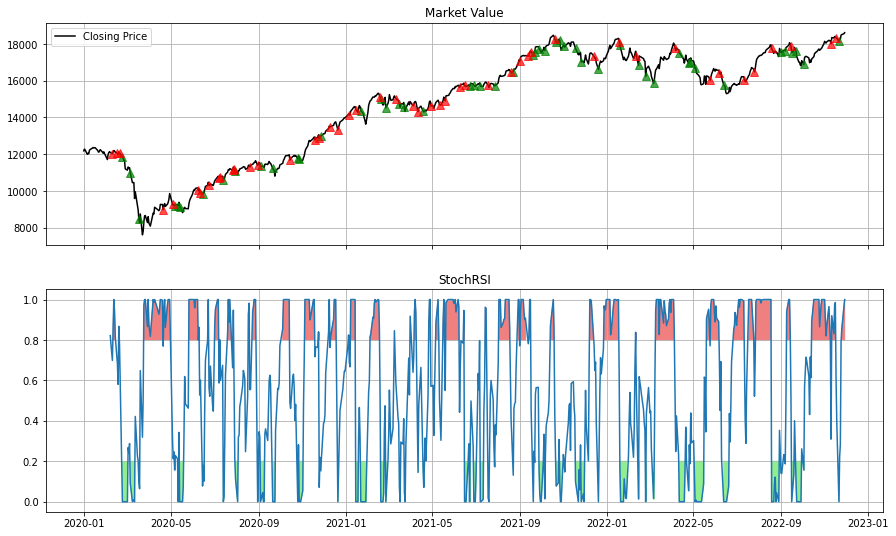

In [182]:
#Running the Indicator
if __name__ == '__main__':
    dataset = download_data()
    dataset['SRSI']=srsi(dataset)
    dataset = srsi_signal(dataset)
    print(dataset[['Close','SRSI']])
    returns(dataset)

    # Plotting Graphs
    fig, axs = plt.subplots(2, sharex=True, figsize=(15,9))
    axs[0].set_title('Market Value')
    axs[0].plot(dataset['Close'],label='Closing Price',color='black')
    axs[0].plot(dataset['Close'][dataset['Signal'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    axs[0].plot(dataset['Close'][dataset['Signal'] == -1], lw=0, marker='^', markersize=8, c='r',alpha=0.7)
    axs[0].grid()
    axs[0].legend()
    axs[1].set_title('StochRSI')
    axs[1].plot(dataset['SRSI'])
    axs[1].grid()
    axs[1].fill_between(dataset.index,dataset.SRSI,0.8,where = dataset.SRSI >= 0.8, color = 'lightcoral')
    axs[1].fill_between(dataset.index,dataset.SRSI,0.2,where = dataset.SRSI <= 0.2, color = 'lightgreen')
    plt.show()

# **PVI Indicator**
The Positive Volume Index (PVI) is an indicator that provides signals for price changes based on positive increases in trading volume.
\
When the PVI is above the one-year average, it helps confirm a price rise. When the PVI drops below the one-year average, it helps confirm a price drop.

### The formula for PVI is:
$$\text{PVI} = \left\{
  \begin{array}{ll}  
  PPVI + \frac{TCP-YCP}{YCP} \times PPVI & \text{Volume Today} > \text{Volume Yesterday} \\
  PPVI & \text{Volume Today} \leq \text{Volume Yesterday}
\end{array}
\right .$$
### where:
$PPVI =$ previous positive volume index \
$TCP =$ today's closing price \
$YCP=$ yesterday's closing price \


In [183]:
# Calculating PVI
def pvi(df):
  df['PVI'] = np.nan
  df['PVI'][1] = df['Close'][1]

  for x in range(2, len(df)):
    if(df['Volume'][x]>df['Volume'][x-1]):
      df['PVI'][x]=df['PVI'][x-1]*(df['Close'][x]/df['Close'][x-1])
    else:
      df['PVI'][x]=df['PVI'][x-1]
  df['PVI_9_mean'] = df['PVI'].rolling(9).mean() 
  df['PVI_255_mean'] = df['PVI'].rolling(255).mean() 

  return df

# **Calculating Returns from PVI**
  Generally high-volume days are associated with the crowd. When the PVI is above its one-year moving average, it means the crowd is optimistic, which helps fuel further price increases. If the PVI falls below the one-year average, the crowd is turning pessimistic, and a price decline is forthcoming.
  PVI is mostly used for confirming trends and reversals and is mostly used with Negative Volume Index (NVI).

>## Buying Condition : 
$$ PVI_\text{today} > \overline{PVI}_\text{today} \quad
\text{and} \quad
PVI_\text{yesterday} \leq \overline{PVI}_\text{yesterday} $$

> ## Selling Condition :
$$ PVI_\text{today} < \overline{PVI}_\text{today} \quad
\text{and} \quad
PVI_\text{yesterday} \geq \overline{PVI}_\text{yesterday} $$

####where :
$\overline{PVI} = $ annual moving average of $PVI$


In [184]:
#Calculating Returns
def pvi_signal(ds):
  ds['Signal']=np.nan

  for x in range(11, len(ds)):
      if(ds['PVI_9_mean'][x]>ds['PVI_255_mean'][x] and ds['PVI_9_mean'][x-1]<=ds['PVI_255_mean'][x-1]):
        ds['Signal'][x]=1
      if(ds['PVI_9_mean'][x]<ds['PVI_255_mean'][x] and ds['PVI_9_mean'][x-1]>=ds['PVI_255_mean'][x-1]):
        ds['Signal'][x]=-1
  return ds

                                  Close  Volume           PVI    PVI_9_mean  \
Date                                                                          
2020-01-01 00:00:00+05:30  12182.500000  304100           NaN           NaN   
2020-01-02 00:00:00+05:30  12282.200195  407700  12282.200195           NaN   
2020-01-03 00:00:00+05:30  12226.650391  428800  12226.650391           NaN   
2020-01-06 00:00:00+05:30  11993.049805  396500  12226.650391           NaN   
2020-01-07 00:00:00+05:30  12052.950195  447800  12287.717521           NaN   
...                                 ...     ...           ...           ...   
2022-11-23 00:00:00+05:30  18267.250000  178800  13493.887306  13551.826450   
2022-11-24 00:00:00+05:30  18484.099609  204000  13654.072566  13559.337642   
2022-11-25 00:00:00+05:30  18512.750000  205900  13675.236405  13569.200372   
2022-11-28 00:00:00+05:30  18562.750000  206500  13712.171049  13583.166951   
2022-11-29 00:00:00+05:30  18618.050781  195300  137

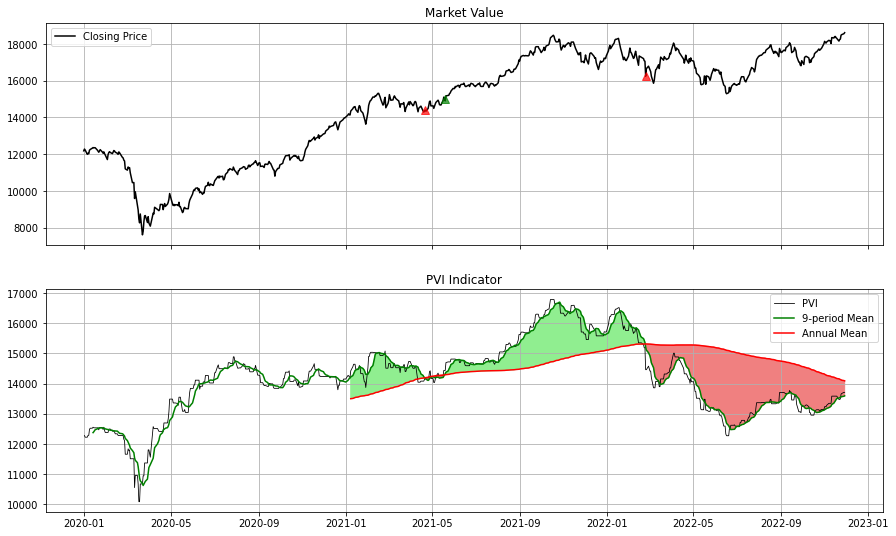

In [185]:
#Running the Indicator
if __name__ == '__main__':
    dataset = download_data()
    dataset=pvi(dataset)
    print(dataset[['Close','Volume','PVI','PVI_9_mean','PVI_255_mean']])
    dataset=pvi_signal(dataset)
    returns(dataset)

    # Plotting Graphs
    fig, axs = plt.subplots(2, sharex=True, figsize=(15,9))
    axs[0].set_title('Market Value')
    axs[0].plot(dataset['Close'],label='Closing Price',color='black')
    axs[0].plot(dataset['Close'][dataset['Signal'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    axs[0].plot(dataset['Close'][dataset['Signal'] == -1], lw=0, marker='^', markersize=8, c='r',alpha=0.7)
    axs[1].set_title('PVI Indicator')
    axs[1].plot(dataset['PVI'],label='PVI',color='black',linewidth=0.8)
    axs[1].plot(dataset['PVI_9_mean'],label='9-period Mean',color='green')
    axs[1].plot(dataset['PVI_255_mean'],label='Annual Mean',color='red')
    axs[1].fill_between(dataset.index,dataset.PVI_9_mean,dataset.PVI_255_mean,where = dataset.PVI_9_mean >= dataset.PVI_255_mean, color = 'lightgreen')
    axs[1].fill_between(dataset.index,dataset.PVI_9_mean,dataset.PVI_255_mean,where = dataset.PVI_9_mean < dataset.PVI_255_mean, color = 'lightcoral')
    for i in range(2):
      axs[i].grid()
      axs[i].legend()
    plt.show()

# **DEMA Indicator**
The Double Exponential Moving Average (DEMA) is a indicator similiar to Moving Average and Exponential Moving Average that gives most weight to recent price data.
\
It is highly sensitive to short term changes which gives the traders more lead time to react.


### The formula for DEMA is:
$$DEMA = (2*EMA(n))-EMA(EMA(n))$$
### where:
$EMA =$ Exponential Moving Average \
$n=$ No. of periods \

In [186]:
def ema(dataset,n):
  df=dataset.copy()
  weight = 2/(n+1)
  df['EMA'] = np.nan
  df['EMA'][n]=df['Close'][1:n+1].mean()
  
  for x in range(n+1,len(df)):
    df['EMA'][x] = (df['Close'][x]*weight) + (df['EMA'][x-1]*(1-weight))
  
  return df['EMA']

def dema(dataset,n):
  df=dataset.copy()
  df['EMA']=ema(df,n)
  weight = 2/(n+1)
  # Calculating EMA(EMA(n))
  df['EMA_EMA'] = np.nan
  df['EMA_EMA'][n]=df['EMA'][1:n+1].mean()

  for x in range(n+1,len(df)):
    df['EMA_EMA'][x] = (df['EMA'][x]*weight) + (df['EMA_EMA'][x-1]*(1-weight))

  df['DEMA'] = (2*df['EMA']) - df['EMA_EMA']
  return df['DEMA']

# **Calculating Returns from DEMA**
  The DEMA is a short term indicator used to confirm reversal signals. It is not used independetly and is mostly used in conjunction with SMA and EMA.  
  Creating a moving average of the security's moving average more effectively cancels out the noise or fluctuations. Then, doubling the EMA increases the magnitude of the line, meaning peaks are sharper and valleys deeper. Thus, the DEMA still reflects a moving average while keeping pace with current, daily changes.

>## Buying Condition : 
$$ {DEMA-50}_\text{today} > {DEMA-200}_\text{today} \quad
\text{and} \quad
{DEMA-50}_\text{yesterday} \leq {DEMA-200}_\text{yesterday} $$

> ## Selling Condition :
$$ {DEMA-50}_\text{today} < {DEMA-200}_\text{today} \quad
\text{and} \quad
{DEMA-50}_\text{yesterday} \geq {DEMA-200}_\text{yesterday} $$



In [187]:
#Calculating Returns
def dema_signal(ds):
  ds['Signal']=np.nan

  for x in range(11, len(ds)):
      if(ds['DEMA_50'][x]>ds['DEMA_200'][x] and ds['DEMA_50'][x-1]<=ds['DEMA_200'][x-1]):
        ds['Signal'][x]=1
      if(ds['DEMA_50'][x]<ds['DEMA_200'][x] and ds['DEMA_50'][x-1]>=ds['DEMA_200'][x-1]):
        ds['Signal'][x]=-1
  return ds

                                  Close       DEMA_50      DEMA_200
Date                                                               
2020-01-01 00:00:00+05:30  12182.500000           NaN           NaN
2020-01-02 00:00:00+05:30  12282.200195           NaN           NaN
2020-01-03 00:00:00+05:30  12226.650391           NaN           NaN
2020-01-06 00:00:00+05:30  11993.049805           NaN           NaN
2020-01-07 00:00:00+05:30  12052.950195           NaN           NaN
...                                 ...           ...           ...
2022-11-23 00:00:00+05:30  18267.250000  18196.060587  17755.474986
2022-11-24 00:00:00+05:30  18484.099609  18233.674695  17775.762832
2022-11-25 00:00:00+05:30  18512.750000  18270.984672  17796.286400
2022-11-28 00:00:00+05:30  18562.750000  18309.642234  17817.464580
2022-11-29 00:00:00+05:30  18618.050781  18349.968797  17839.392227

[723 rows x 3 columns]
trades done= 1
trades open= 1
Percentage returns 15.180298828125 %
No. of trades with profit

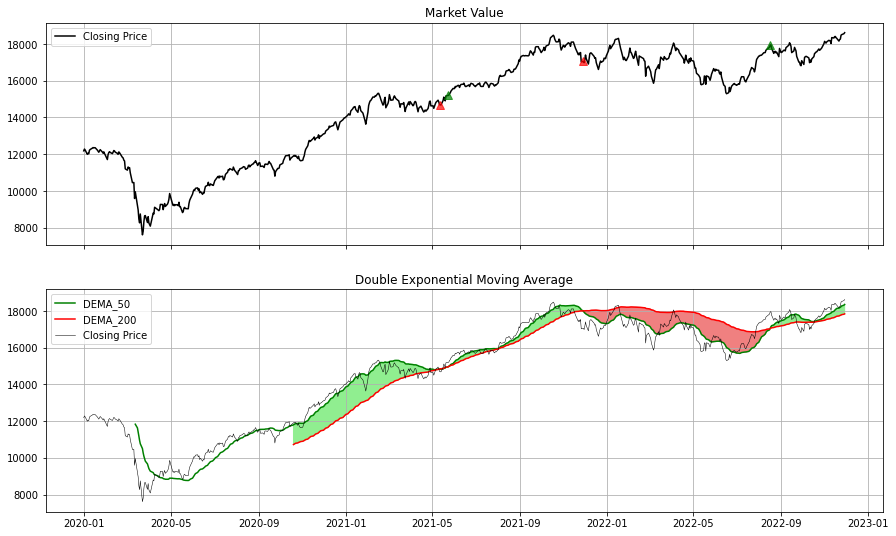

In [188]:
#Running the Indicator
if __name__ == '__main__':
    dataset = download_data()
    dataset['DEMA_50'] = dema(dataset,50)
    dataset['DEMA_200'] = dema(dataset,200)
    print(dataset[['Close','DEMA_50','DEMA_200']])
    dataset = dema_signal(dataset)
    returns(dataset)

    # Plotting Graphs
    fig, axs = plt.subplots(2, sharex=True, figsize=(15,9))
    axs[0].set_title('Market Value')
    axs[0].plot(dataset['Close'],label='Closing Price',color='black')
    axs[0].plot(dataset['Close'][dataset['Signal'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    axs[0].plot(dataset['Close'][dataset['Signal'] == -1], lw=0, marker='^', markersize=8, c='r',alpha=0.7)
    axs[1].set_title('Double Exponential Moving Average')
    axs[1].plot(dataset['DEMA_50'],label='DEMA_50',color='green')
    axs[1].plot(dataset['DEMA_200'],label='DEMA_200',color='red')
    axs[1].plot(dataset['Close'],label='Closing Price',color='black',linewidth='0.5')
    for i in range(2):
      axs[i].grid()
      axs[i].legend()
    axs[1].fill_between(dataset.index,dataset.DEMA_50,dataset.DEMA_200,where = dataset.DEMA_50 >= dataset.DEMA_200, color = 'lightgreen')
    axs[1].fill_between(dataset.index,dataset.DEMA_50,dataset.DEMA_200,where = dataset.DEMA_50 < dataset.DEMA_200, color = 'lightcoral')
    plt.show()

# **Chaikin Oscillator Indicator**
The Chaikin Oscillator applies the MACD (Moving Average Convergence-Divergence) to the accumulation-distribution line rather than to the closing price which gives information about the future direction of stock price.



### The formula for Chaikin Oscillator is:
$$N = \frac {\text{(Close - Low) - (High - Close)}}{\text{High - Low}}$$
\
$$M= N*\text{Volume}$$
\
$$\text{ADL}=M_{\text{yesterday}} + M_{\text{today}}$$
\
$$CO = \text{3-day EMA of ADL} - \text{10-day EMA of ADL}$$

### where:
$N =$ Money flow Multiplier \
$M =$ Money flow volume \
$\text{ADL} =$ Accumulation distribution line \
$CO =$ Chaikin Oscillator \

In [189]:
# Calculating Chaikin Oscillator
def chaikin_ema(dataset,n):
  df=dataset.copy()
  weight = 2/(n+1)
  df['EMA'] = np.nan
  df['EMA'][n]=df['ADL'][1:n+1].mean()
  
  for x in range(n+1,len(df)):
    df['EMA'][x] = (df['ADL'][x]*weight) + (df['EMA'][x-1]*(1-weight))
  
  return df['EMA']

def chaikin(dataset):
  df=dataset.copy()
  df['N'] = (df['Close']-df['Low']-df['High']+df['Close']) / (df['High']-df['Low'])
  df['M'] = df['N']*df['Volume']
  df['ADL'] = df['M'].cumsum()
  df['3-EMA'] = chaikin_ema(df,3)
  df['10-EMA'] = chaikin_ema(df,10)
  df['CO'] = df['3-EMA'] - df['10-EMA']
  return df['CO']

# **Calculating Returns from Chaikin Oscillator**
  The purpose of the Chaikin oscillator is to identify underlying momentum during fluctuations in accumulation and distribution. Specifically, it applies the MACD indicator to accumulation-distribution rather than closing prices.  

The Chaikin oscillator utilizes two primary buy and sell signals. First, a positive divergence is confirmed with a center-line crossover above the accumulation-distribution line, signaling a potential buying opportunity. Second, a negative divergence is confirmed with a center-line crossover below the accumulation-distribution line, signaling a potential selling opportunity. 

A positive divergence signals a stock price is likely to rise, given the increase in accumulation. A negative divergence signals a stock price is likely to fall, given the increase in distribution.

>## Buying Condition : 
$$ CO_\text{today} > 0 \quad
\text{and} \quad
CO_\text{yesterday} \leq 0 $$

> ## Selling Condition :
$$ CO_\text{today} < 0 \quad
\text{and} \quad
CO_\text{yesterday} \geq 0 $$



In [190]:
#Calculating Returns
def chaikin_signal(ds):
  ds['Signal']=np.nan

  for x in range(11, len(ds)):
      if(ds['Chaikin'][x]>0 and ds['Chaikin'][x-1]<=0):
        ds['Signal'][x]=1
      if(ds['Chaikin'][x]<0 and ds['Chaikin'][x-1]>=0):
        ds['Signal'][x]=-1
  return ds

                                  Close        Chaikin
Date                                                  
2020-01-01 00:00:00+05:30  12182.500000            NaN
2020-01-02 00:00:00+05:30  12282.200195            NaN
2020-01-03 00:00:00+05:30  12226.650391            NaN
2020-01-06 00:00:00+05:30  11993.049805            NaN
2020-01-07 00:00:00+05:30  12052.950195            NaN
...                                 ...            ...
2022-11-23 00:00:00+05:30  18267.250000   35105.847758
2022-11-24 00:00:00+05:30  18484.099609   60528.121933
2022-11-25 00:00:00+05:30  18512.750000   98619.846353
2022-11-28 00:00:00+05:30  18562.750000  143724.726304
2022-11-29 00:00:00+05:30  18618.050781  151997.886226

[723 rows x 2 columns]
trades done= 31
trades open= 1
Percentage returns 57.214392578125 %
No. of trades with profit=  14


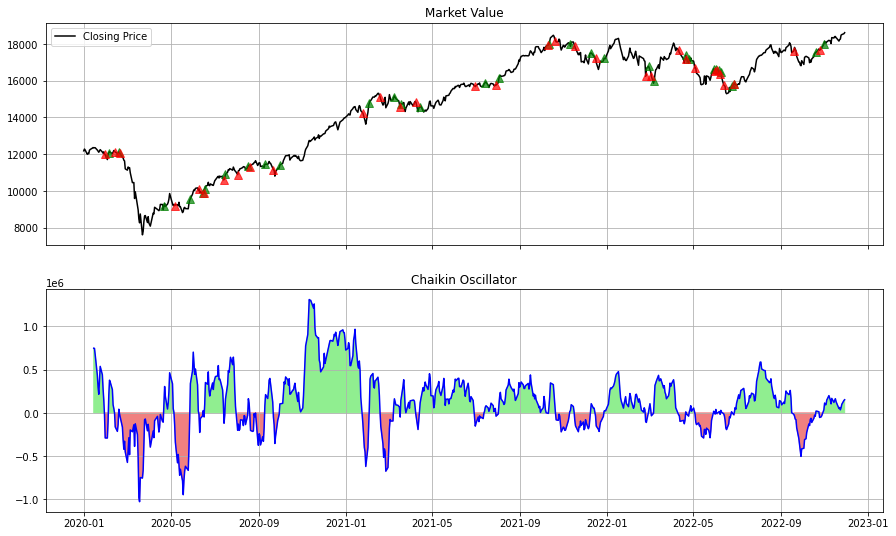

In [191]:
#Running the Indicator
if __name__ == '__main__':
    dataset = download_data()
    dataset['Chaikin'] = chaikin(dataset)
    dataset = chaikin_signal(dataset)
    print(dataset[['Close','Chaikin']])
    returns(dataset)
    
    # Plotting Graphs
    fig, axs = plt.subplots(2, sharex=True, figsize=(15,9))
    axs[0].set_title('Market Value')
    axs[0].plot(dataset['Close'],label='Closing Price',color='black')
    axs[0].plot(dataset['Close'][dataset['Signal'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)
    axs[0].plot(dataset['Close'][dataset['Signal'] == -1], lw=0, marker='^', markersize=8, c='r',alpha=0.7)
    axs[0].grid()
    axs[0].legend()
    axs[1].set_title('Chaikin Oscillator')
    axs[1].plot(dataset['Chaikin'],color='blue')
    axs[1].grid()
    axs[1].fill_between(dataset.index,dataset.Chaikin,0,where = dataset.Chaikin >= 0, color = 'lightgreen')
    axs[1].fill_between(dataset.index,dataset.Chaikin,0,where = dataset.Chaikin < 0, color = 'lightcoral')
    plt.show()